# Exploratory Data Analysis
Data Overlook 
 - [Bigotry Confidence Decision](#Bigotry-Confidence-Decision)

[Create Text Features](#Create-Text-Features)

[Text Cleaning](#Text-Cleaning)

[Emotion Sensor Dataset](#Emotion-Sensor-Dataset)
 - [Combining the Datasets](#Combining-the-Datasets)

[Exploring Features with Visualization](#Exploring-Features)

[Naive Bayes for Predictive Words](#Naive-Bayes-for-Predictive-Words)

[Emotion Feature Ranking with Random Forest](#Emotion-Sensor-Feature-Ranking-with-Random-Forest)


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv(r'/Users/michelstahli/Spring 2022 (Bootcamp+)/Jupyter Notebook CSVs/rbig_booled.csv', index_col=0)

In [4]:
df.head()

,num_id,reviewers,bigotry,bigotry_c,directed,directed_c,sentiment_comment,sentcom_c,sentiment_topic,senttop_c,author_name,text,id,overall_sentiment_score,subreddit,subreddit_id,ups
0,684790497,3,False,0.6585,True,1.0000,neutral,1.0000,neutral,1.0000,UFOabductee,Is this where I'm supposed to start a Linux fl...,t1_c15vcg9,-1.396659,announcements,t5_2r0ij,132
1,684790498,3,False,1.0000,True,1.0000,neutral,1.0000,neutral,1.0000,RaiseYourGlass,"Yeah man, back then OS's didn't need viruses t...",t1_c15wddg,0.688598,announcements,t5_2r0ij,13
2,684790499,3,False,1.0000,True,0.6492,neutral,0.6492,neutral,1.0000,raldi,"&gt; I just extended for a year, verified, and...",t1_c16z039,-0.413420,announcements,t5_2r0ij,8
3,684790500,3,False,1.0000,True,0.6578,neutral,0.3602,neutral,0.7024,TheCid,The hell? That many people getting r/lounge ac...,t1_c16zi8e,-0.880108,announcements,t5_2r0ij,2
4,684790501,3,False,1.0000,True,1.0000,positive,1.0000,positive,1.0000,eunos,Worked perfectly! I'm glad to have given back ...,t1_c17051h,3.160947,announcements,t5_2r0ij,2


As a reminder, we have missing data for sentiment_comment and sentcom_c. If we decide to include this in our model we need to deal with this.

### Bigotry Confidence Decision
(Low confidence in bigotry seems to mostly affect cases where bigotry==True)

In [5]:
#Only use bigotry confidence = 1, since so many observations
y = (df['bigotry'] == True).values.astype(int)
print("All confidence:")
print(y.sum())
df_big = df[df['bigotry_c'] >= 1]
y = (df_big['bigotry'] == True).values.astype(int)
print("Unanimous:")
print(y.sum())
df_big = df[df['bigotry_c'] >= 0.66]
y = (df_big['bigotry'] == True).values.astype(int)
print("Greater than or equal 0.66:")
print(y.sum())
print(df['reviewers'].unique())
df_big = df[df['bigotry_c'] >= 0.667]
y = (df_big['bigotry'] == True).values.astype(int)
print("Greater than 0.67:")
print(y.sum())

All confidence:
921
Unanimous:
236
Greater than or equal 0.66:
608
[3 4 5]
Greater than 0.67:
549


Currently using greater than 0.67 confidence for bigotry. 

In [6]:
#Number of reviewers fixed itself
print(df_big['reviewers'].unique())

[3 4 5]


## Create Text Features
### readability, word count, upper/lower case

In [6]:
#Let's create some text features
#pip install textstat
import textstat

In [7]:
dal = df_big['text'].apply(textstat.dale_chall_readability_score)
testan = df_big['text'].apply(textstat.text_standard)
readt = pd.DataFrame({'dal':dal, 'testan':testan})

In [8]:
df_big['dal'] = readt['dal']
df_big['testan'] = readt['testan']

In [9]:
df_complicated_words = df_big[df_big['dal'] > 11.83]
df_complicated_words = df_complicated_words[df_complicated_words['ups'] > 15]
df_complicated_words = df_complicated_words.text
print(df_big.dal.quantile(0.90))
df_complicated_words.shape
#Should probably filter for non-letter - see below example

11.78


(171,)

In [10]:
df_big['word_count'] = df_big['text'].str.split().map(len)

#|print(list(df_big[df_big['Unnamed: 0'] == 1].text), df_big[df_big['Unnamed: 0'] == 1].word_count )

In [11]:
df_big.head()

,num_id,reviewers,bigotry,bigotry_c,directed,directed_c,sentiment_comment,sentcom_c,sentiment_topic,senttop_c,author_name,text,id,overall_sentiment_score,subreddit,subreddit_id,ups,dal,testan,word_count
1,684790498,3,False,1.0,True,1.0000,neutral,1.0000,neutral,1.0000,RaiseYourGlass,"Yeah man, back then OS's didn't need viruses t...",t1_c15wddg,0.688598,announcements,t5_2r0ij,13,8.38,6th and 7th grade,16
2,684790499,3,False,1.0,True,0.6492,neutral,0.6492,neutral,1.0000,raldi,"&gt; I just extended for a year, verified, and...",t1_c16z039,-0.413420,announcements,t5_2r0ij,8,11.38,6th and 7th grade,38
3,684790500,3,False,1.0,True,0.6578,neutral,0.3602,neutral,0.7024,TheCid,The hell? That many people getting r/lounge ac...,t1_c16zi8e,-0.880108,announcements,t5_2r0ij,2,8.18,4th and 5th grade,12
4,684790501,3,False,1.0,True,1.0000,positive,1.0000,positive,1.0000,eunos,Worked perfectly! I'm glad to have given back ...,t1_c17051h,3.160947,announcements,t5_2r0ij,2,10.09,11th and 12th grade,41
5,684790502,3,False,1.0,True,0.6862,positive,0.3633,positive,0.3633,Player-Hater,This is so bullshit. Why doesn't anyone gift m...,t1_c17qrth,-1.269243,announcements,t5_2r0ij,2,7.04,1st and 2nd grade,10


In [12]:
df_big.iloc[0, 11]

"Yeah man, back then OS's didn't need viruses to crash, they just did it by themselves!"

In [13]:
#Get upper/lower case info 
df_big['uppercase'] = df_big['text'].str.findall(r'[A-Z]').str.len()
df_big['lowercase'] = df_big['text'].str.findall(r'[a-z]').str.len()
df_big['up_low_ratio'] = df_big['uppercase']/(df_big['uppercase']+df_big['lowercase'])
df_big['caps>50'] = np.where(df_big['up_low_ratio']>0.5, True, False)
print(df_big[df_big['caps>50']==True].shape)
print(df_big[df_big['caps>50']==False].shape)

(215, 24)
(8710, 24)


## Text Cleaning

In [14]:
import re

***Lower case***

In [15]:
df_aug = df_big
df_aug['text']=df_aug['text'].apply(lambda x: x.lower())

***Contraction expansion***

In [16]:
#Code from https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/#5
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions
df_aug['text']=df_aug['text'].apply(lambda x:expand_contractions(x))

***Digits, punctuation, spaces***

In [17]:
df_aug['text']= df_aug['text'].apply(lambda x: re.sub('\w*\d\w*','', x)) #digits and words with digits
df_aug['text']= df_aug['text'].apply(lambda x: re.sub(r'[^\w\d\s]+','', x)) #punctuation
df_aug['text']= df_aug['text'].apply(lambda x: str.strip(x)) #extra spaces

***Lemmatization***

In [18]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, WhitespaceTokenizer
import nltk
nltk.download('omw-1.4') #Gave error and said to do this 

w_tokenizer = WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

df_aug['text_lemmatized'] = df_aug['text'].apply(lambda x: lemmatize_text(x))

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/michelstahli/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [65]:
#df_pre.to_csv(r'/Users/michelstahli/Spring 2022 (Bootcamp+)/Jupyter Notebook CSVs/df_pre_filt.csv')
#df_pre_filt = pd.read_csv(r'/Users/michelstahli/Spring 2022 (Bootcamp+)/Jupyter Notebook CSVs/df_pre_filt.csv')

### Emotion Sensor Dataset

In [63]:
emotion_df = pd.read_csv('Andbrain_DataSet.csv')
emotion_df['word'] = emotion_df['word'].str.strip()
print(emotion_df.head())

      word   disgust  surprise   neutral     anger       sad     happy  \
0  ability  0.004464  0.047832  0.000638  0.023597  0.013393  0.015944   
1     able  0.000017  0.000182  0.000409  0.000176  0.000219  0.000244   
2    abuse  0.000532  0.000177  0.000177  0.137363  0.001241  0.001595   
3  academy  0.007143  0.021429  0.007143  0.007143  0.007143  0.092857   
4   accept  0.008271  0.006767  0.000752  0.048872  0.018797  0.024812   

       fear  
0  0.040179  
1  0.000186  
2  0.002659  
3  0.035714  
4  0.038346  


#### Combining the Datasets

In [64]:
def emotion_func(document):
    the_list = []
    for word in document:
        if word in emotion_df['word'].values:
            the_list.append(word)
    return the_list

df_aug['emotion_words'] = df_aug['text_lemmatized'].apply(emotion_func)
      

In [66]:
def emo_func(column_name, list_of_words):
    return emotion_df[emotion_df['word'].isin(list_of_words)][column_name].mean()

In [67]:
for column in emotion_df.columns[1:]:
    df_aug[column] = df_aug['emotion_words'].apply(lambda x: emo_func(column, x))

In [7]:
#df_aug.head()

***Get rid of unnecessary columns for final model***

In [69]:
df_post_eda = df_aug.drop(columns=['num_id', 'text', 'subreddit', 'sentcom_c', 'senttop_c', 'author_name', 'uppercase', 'lowercase', 'caps>50', 'directed_c', 'bigotry_c', 'reviewers', 'subreddit_id', 'id', 'emotion_words', 'testan'])

,bigotry,directed,sentiment_comment,sentiment_topic,overall_sentiment_score,ups,dal,word_count,up_low_ratio,text_lemmatized,disgust,surprise,neutral,anger,sad,happy,fear
1,False,True,neutral,neutral,0.688598,13,8.38,16,0.045455,"[yeah, man, back, then, o, is, did, not, need,...",0.015762,0.026123,0.003467,0.017550,0.032248,0.024791,0.040254
2,False,True,neutral,neutral,-0.413420,8,11.38,38,0.035211,"[gt, i, just, extended, for, a, year, verified...",0.005102,0.035714,0.005102,0.025510,0.045918,0.005102,0.045918
3,False,True,neutral,neutral,-0.880108,2,8.18,12,0.035088,"[the, hell, that, many, people, getting, rloun...",0.007692,0.010889,0.000100,0.068831,0.027073,0.015085,0.013686
4,False,True,positive,positive,3.160947,2,10.09,41,0.043269,"[worked, perfectly, im, glad, to, have, given,...",0.001270,0.017361,0.000836,0.007215,0.016621,0.018059,0.013498
5,False,True,positive,positive,-1.269243,2,7.04,10,0.044444,"[this, is, so, bullshit, why, doe, not, anyone...",0.000002,0.000046,0.000736,0.000042,0.000046,0.000553,0.000013


In [70]:
df_model_features = df_post_eda.drop(columns=['directed', 'sentiment_comment', 'sentiment_topic', 'overall_sentiment_score'])

In [71]:
df_model_features.head()

,bigotry,ups,dal,word_count,up_low_ratio,text_lemmatized,disgust,surprise,neutral,anger,sad,happy,fear
1,False,13,8.38,16,0.045455,"[yeah, man, back, then, o, is, did, not, need,...",0.015762,0.026123,0.003467,0.017550,0.032248,0.024791,0.040254
2,False,8,11.38,38,0.035211,"[gt, i, just, extended, for, a, year, verified...",0.005102,0.035714,0.005102,0.025510,0.045918,0.005102,0.045918
3,False,2,8.18,12,0.035088,"[the, hell, that, many, people, getting, rloun...",0.007692,0.010889,0.000100,0.068831,0.027073,0.015085,0.013686
4,False,2,10.09,41,0.043269,"[worked, perfectly, im, glad, to, have, given,...",0.001270,0.017361,0.000836,0.007215,0.016621,0.018059,0.013498
5,False,2,7.04,10,0.044444,"[this, is, so, bullshit, why, doe, not, anyone...",0.000002,0.000046,0.000736,0.000042,0.000046,0.000553,0.000013


In [52]:
df_post_eda.to_csv(r'/Users/michelstahli/Spring 2022 (Bootcamp+)/Jupyter Notebook CSVs/df_post_eda.csv')

## Exploring Features

Text(0.5, 1.0, 'Feature Correlation Heatmap')

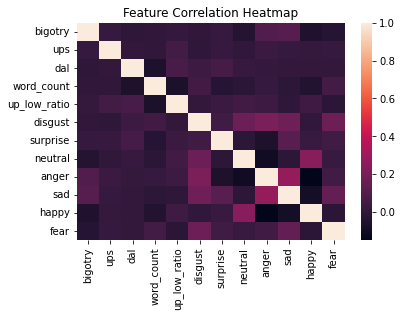

In [28]:
ax = sns.heatmap(df_model_features.corr())
ax.set_title('Feature Correlation Heatmap')

In [29]:
df_model_features.corr()


,bigotry,ups,dal,word_count,up_low_ratio,disgust,surprise,neutral,anger,sad,happy,fear
bigotry,1.000000,0.013233,-0.009064,-0.000094,0.008555,-0.002404,0.014907,-0.043054,0.089326,0.105283,-0.053634,-0.035209
ups,0.013233,1.000000,0.005714,-0.001845,0.054906,-0.007463,0.019286,-0.001794,0.027751,0.014668,0.007973,0.014606
dal,-0.009064,0.005714,1.000000,-0.061971,0.066917,0.033859,0.057255,0.015570,0.008348,0.005658,0.002911,0.003956
word_count,-0.000094,-0.001845,-0.061971,1.000000,-0.069231,0.050580,-0.036361,-0.021289,0.013328,-0.014469,-0.044902,0.054848
up_low_ratio,0.008555,0.054906,0.066917,-0.069231,1.000000,0.005058,0.025620,0.047868,0.030071,-0.011100,0.041872,-0.016366
disgust,-0.002404,-0.007463,0.033859,0.050580,0.005058,1.000000,0.045895,0.166763,0.204457,0.173039,-0.000925,0.164041
surprise,0.014907,0.019286,0.057255,-0.036361,0.025620,0.045895,1.000000,-0.012499,-0.063253,0.113595,0.022056,0.044273
neutral,-0.043054,-0.001794,0.015570,-0.021289,0.047868,0.166763,-0.012499,1.000000,-0.098099,-0.015765,0.244205,0.021573
anger,0.089326,0.027751,0.008348,0.013328,0.030071,0.204457,-0.063253,-0.098099,1.000000,0.277277,-0.151092,0.043372
sad,0.105283,0.014668,0.005658,-0.014469,-0.011100,0.173039,0.113595,-0.015765,0.277277,1.000000,-0.091993,0.143047


In [30]:
df_model_features[['disgust', 'surprise', 'neutral', 'anger', 'sad',
       'happy', 'fear']].max()

disgust     0.107535
surprise    0.135056
neutral     0.035714
anger       0.134997
sad         0.109788
happy       0.137363
fear        0.140538
dtype: float64

In [31]:
(df_model_features.isna().sum())/df_model_features.shape[0]

bigotry            0.000000
ups                0.000000
dal                0.000000
word_count         0.000000
up_low_ratio       0.000336
text_lemmatized    0.000000
disgust            0.209076
surprise           0.209076
neutral            0.209076
anger              0.209076
sad                0.209076
happy              0.209076
fear               0.209076
dtype: float64

In [32]:
'''df_model_features[['disgust', 'surprise', 'neutral', 'anger', 'sad',
       'happy', 'fear']] = df_model_features[['disgust', 'surprise', 'neutral', 'anger', 'sad',
       'happy', 'fear']].fillna(0)'''

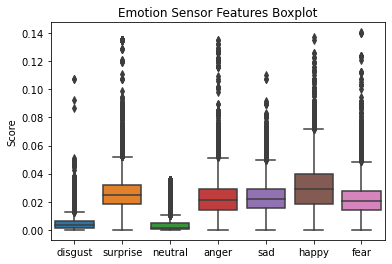

In [72]:
boxy = sns.boxplot(data=df_model_features[['disgust', 'surprise', 'neutral', 'anger', 'sad',
       'happy', 'fear']])
boxy.set_title('Emotion Sensor Features Boxplot')
boxy.set_ylabel('Score')
plt.show()

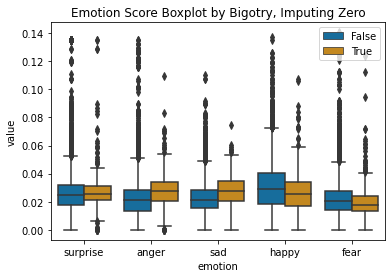

In [81]:
longer = pd.melt(df_model_features[['surprise', 'anger', 'sad',
       'happy', 'fear', 'bigotry']], id_vars=['bigotry'], value_vars=['surprise', 'anger', 'sad',
       'happy', 'fear'])
longer = longer.rename(columns={'variable':'emotion'})

long = sns.boxplot(data=longer, x='emotion', y='value', hue='bigotry')
long.set_title('Emotion Score Boxplot by Bigotry, Imputing Zero')
long.legend(loc='upper right')
plt.show()

451.17


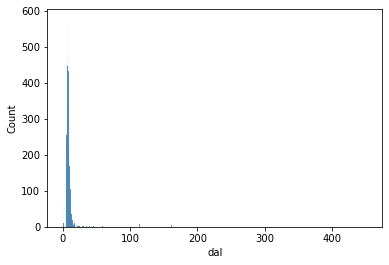

In [35]:
sns.histplot(df_model_features['dal'])
print(df_model_features['dal'].max())

In [36]:
large_dal = df_model_features[df_model_features['dal']>100]
small_dal = df_model_features[df_model_features['dal']<=100]
large_dal.shape

(26, 13)

<AxesSubplot:xlabel='dal', ylabel='Count'>

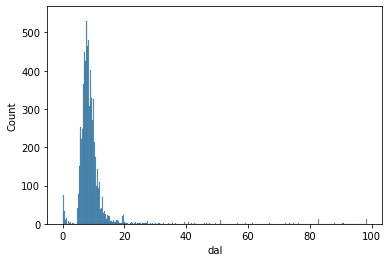

In [37]:
sns.histplot(small_dal['dal'])

In [39]:
from scipy.stats import mannwhitneyu
yes = df_model_features[df_model_features['bigotry']==True]
no = df_model_features[df_model_features['bigotry']==False]

mannwhitneyu(yes['anger'], no['anger'])

MannwhitneyuResult(statistic=3099394.5, pvalue=5.460122531602824e-43)

<AxesSubplot:>

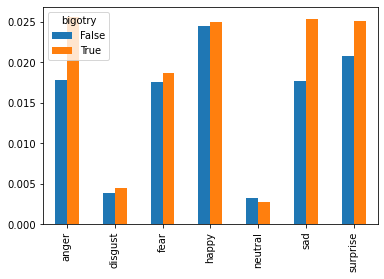

In [40]:
pivot_emotions = pd.pivot_table(df_model_features[['disgust', 'surprise', 'neutral', 'anger', 'sad',
       'happy', 'fear', 'bigotry']], columns='bigotry')  
pivot_emotions

pivot_emotions.plot(kind='bar')

# Naive Bayes for Predictive Words

In [44]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score, recall_score, classification_report


In [44]:
y = (df_post_eda['bigotry'] == True).values.astype(int)
X = df_post_eda['text_lemmatized']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26, stratify=y)

In [46]:
X_train.head()

2013    [traveling, first, down, kicking, the, chop, b...
8374    [if, this, dude, said, any, of, this, in, a, l...
4263    [of, cheese, for, what, is, over, of, food, do...
2674    [what, make, them, child, is, movie, the, scif...
4921    [because, i, did, not, take, a, position, i, h...
Name: text_lemmatized, dtype: object

In [103]:
vectorizer = CountVectorizer(min_df=3, max_df=0.8, analyzer=lambda x:x)
X_vec = vectorizer.fit_transform(X_train)

model = MultinomialNB()
model.fit(X_vec, y_train)
x_test_eye = np.eye(X_vec.shape[1])
predicted = model.predict_log_proba(x_test_eye)[:,0]
df = zip(vectorizer.get_feature_names_out(), 1 - np.exp(predicted))
list_of_tuples = list(df)
df = pd.DataFrame(list_of_tuples, columns = ['word', 'probability'])
df = df.round(decimals=4)

In [104]:
X_train.shape

(7140,)

In [105]:
df.sort_values(by=['probability'], inplace=True)
df.head(15)

,word,probability
1825,gem,0.0020
1863,glass,0.0052
4418,thank,0.0056
2502,le,0.0080
1605,favorite,0.0084
2973,nope,0.0087
2421,keyboard,0.0090
2801,minute,0.0095
4047,small,0.0096
4116,sound,0.0106


In [106]:
df.sort_values(by=['probability'], ascending=False, inplace=True)
df.head(15)

,word,probability
1570,faggot,0.8792
2954,nigga,0.8675
2955,nigger,0.8359
450,bigoted,0.7443
2804,misogynistic,0.7443
10,aboriginal,0.7443
3195,penis,0.7081
2855,motherfucker,0.6599
1821,gay,0.6359
1042,cunt,0.6335


In [60]:
X_vec

<7140x307 sparse matrix of type '<class 'numpy.int64'>'
	with 102276 stored elements in Compressed Sparse Row format>

## Emotion Sensor Feature Ranking with Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef, make_scorer, roc_auc_score, roc_curve, PrecisionRecallDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

Only choose comments with emotion sensor words 

In [45]:
df_post_edas = df_post_eda.dropna()
y = (df_post_edas['bigotry'] == True).values.astype(int)
X = df_post_edas[['disgust', 'surprise', 'neutral', 'anger', 'sad',
       'happy', 'fear']]

In [46]:
X_trainE, X_testE, y_trainE, y_testE = train_test_split(X, y, test_size=0.2, random_state=26, stratify=y)

For ROC AUC 

Accuracy: 0.6877275671811827
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1006
           1       0.00      0.00      0.00        89

    accuracy                           0.92      1095
   macro avg       0.46      0.50      0.48      1095
weighted avg       0.84      0.92      0.88      1095

Tuned Model Parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'n_estimators': 10}
Matthew Corr: 0.0
ROC AUC score: 0.6877275671811827


/Users/michelstahli/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michelstahli/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michelstahli/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

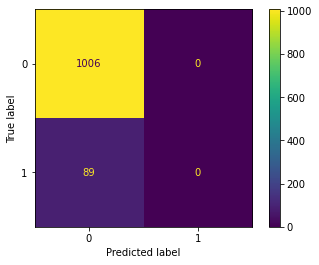

In [124]:
#GridSearch
fclassifier = RandomForestClassifier(random_state=26)


parameter_grid = {
                    'criterion': ["gini", "entropy", "log_loss"],
                    'max_depth': [3, 5, 10, 15],
                    'n_estimators': [10, 15, 50, 100],
                    'max_features': [None]
                
                    }
fcv = GridSearchCV(fclassifier, parameter_grid, scoring='roc_auc', error_score='raise', cv=4)
fcv.fit(X_trainE, y=y_trainE)

# Predict the labels of the test set: y_pred
fy_pred = fcv.predict(X_testE)

fcm = confusion_matrix(y_testE, fy_pred, labels=fcv.classes_)
# Compute and print metrics
print('For ROC AUC','\n')
print("Accuracy: {}".format(fcv.score(X_testE, y_testE)))
print(classification_report(y_testE, fy_pred))
print("Tuned Model Parameters: {}".format(fcv.best_params_))
print('Matthew Corr:', matthews_corrcoef(y_testE, fy_pred))
print('ROC AUC score:',roc_auc_score(y_testE, fcv.predict_proba(X_testE)[:, 1]))
fdisp = ConfusionMatrixDisplay(fcm, display_labels=fcv.classes_)
fdisp.plot()
plt.show()

In [47]:
features_forest_please = RandomForestClassifier(random_state=26, criterion='gini', max_depth=5, max_features=None, n_estimators=10)
features_forest_please.fit(X_trainE, y_trainE)

RandomForestClassifier(max_depth=5, max_features=None, n_estimators=10,
                       random_state=26)

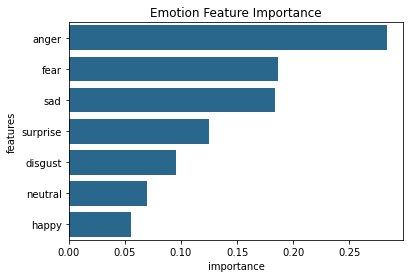

In [83]:
def feature_plotter_f(model):
    modlist = list(zip(X_trainE.columns, model.feature_importances_))
    features_df = pd.DataFrame(modlist, columns=['features', 'importance'])
    features_df = features_df.sort_values(by='importance', ascending=False)
    features_df[:15]
    sns.barplot(y=features_df['features'][:15], x=features_df['importance'][:15], orient='h', color='#186c9c')
    #ax = plt.barh(features_df['features'][:15], features_df['importance'][:15])
    plt.title('Emotion Feature Importance')
    #ax.invert_yaxis()
    plt.show()
feature_plotter_f(features_forest_please)